In [1]:
import yfinance as yf
import pandas as pd
import random
import numpy as np
import pendulum

In [2]:
class Volume:
    def __init__(self, value: float):
        self.value = value

class Dollar:
    def __init__(self, value: float):
        self.value = value


In [3]:
#Import the data.
btc_ts = yf.Ticker("BTC-USD").history(start='2016-01-01', end='2023-06-30')


In [4]:
base_columns_list = ['Open', 'High', 'Low', 'Close', 'Volume']
# btc_train = btc_train[base_columns_list]

# base_column_mapping = {}
# for i in base_columns_list:
#     base_column_mapping[i]=i.lower()
# btc_train = btc_train.rename(columns = base_column_mapping)
# btc_train.head(5)
# base_columns_list = [i.lower() for i in base_columns_list]

In [5]:
def create_ma_columns(df,column, lag):
    df[f"ma_{column.lower()}_{lag}"]= df[column].rolling(window = lag).mean()
    return df

def create_lagged_columns(df, column, lag):
    df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
    return df

def create_percentage_of_value(df, column, percentage:float = random.random()):
    df[f"percentage_{column.lower()}_{(round(percentage*100))}"]= df[column]*percentage
    return df

def create_difference(df, column1:str = "low", column2:str = "high"):
    df[f"difference_{column1.lower()}_{column2.lower()}"]= df[column2]-df[column1]
    return df

In [6]:
# Add columns to df:
for column in base_columns_list:
    for lag in range(2,50):
        create_ma_columns(df = btc_ts,column=column, lag = lag)
    for lag in range(1,50):
        create_lagged_columns(df = btc_ts,column=column, lag = lag)
    for lag in range(10):
        create_percentage_of_value(df = btc_ts,column=column)

/tmp/ipykernel_768564/3535242035.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/tmp/ipykernel_768564/3535242035.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/tmp/ipykernel_768564/3535242035.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [7]:
btc_ts.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma_open_2,ma_open_3,ma_open_4,...,lag_volume_41,lag_volume_42,lag_volume_43,lag_volume_44,lag_volume_45,lag_volume_46,lag_volume_47,lag_volume_48,lag_volume_49,percentage_volume_46
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,36278900,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.660963e+07
2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,30096600,0.0,0.0,432.671509,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.377918e+07
2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,39633800,0.0,0.0,434.100006,432.973674,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.814561e+07
2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,38477500,0.0,0.0,431.819504,432.753672,432.245506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.761622e+07
2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,34522600,0.0,0.0,431.565002,432.236003,432.832504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580554e+07


In [8]:
def pre_process(df):
    """Remove nulls and columns from the DF."""
    null_rows = df.isna().sum(axis=1)[df.isna().sum(axis=1)!=0]
    null_row_indices = list(null_rows.index)
    df.drop(null_row_indices,inplace=True)
    # sum(df.isna().sum(axis=1))
    df.drop(['Dividends','Stock Splits'], axis=1,inplace = True)
    return df

In [9]:
btc_ts = pre_process(btc_ts)

In [10]:
btc_ts.head()

,Open,High,Low,Close,Volume,ma_open_2,ma_open_3,ma_open_4,ma_open_5,ma_open_6,...,lag_volume_41,lag_volume_42,lag_volume_43,lag_volume_44,lag_volume_45,lag_volume_46,lag_volume_47,lag_volume_48,lag_volume_49,percentage_volume_46
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-19 00:00:00+00:00,422.730011,423.104004,417.604004,420.785004,55711300,419.651001,415.652669,412.097504,411.191602,408.148336,...,32278000.0,56993000.0,87562200.0,34042500.0,34522600.0,38477500.0,39633800.0,30096600.0,36278900.0,2.550640e+07
2016-02-20 00:00:00+00:00,421.601013,441.984009,421.601013,437.164001,93992096,422.165512,420.301005,417.139755,413.998206,412.926503,...,35995900.0,32278000.0,56993000.0,87562200.0,34042500.0,34522600.0,38477500.0,39633800.0,30096600.0,4.303256e+07
2016-02-21 00:00:00+00:00,437.773010,448.045990,429.076996,438.798004,89820704,429.687012,427.368011,424.669006,421.266406,417.960673,...,40450000.0,35995900.0,32278000.0,56993000.0,87562200.0,34042500.0,34522600.0,38477500.0,39633800.0,4.112277e+07
2016-02-22 00:00:00+00:00,438.989014,439.045013,432.916992,437.747986,85385200,438.381012,432.787679,430.273262,427.533008,424.220174,...,115607000.0,40450000.0,35995900.0,32278000.0,56993000.0,87562200.0,34042500.0,34522600.0,38477500.0,3.909205e+07
2016-02-23 00:00:00+00:00,438.255005,439.858002,417.821014,420.735992,85244896,438.622009,438.339010,434.154510,431.869611,429.320007,...,173888000.0,115607000.0,40450000.0,35995900.0,32278000.0,56993000.0,87562200.0,34042500.0,34522600.0,3.902782e+07


In [11]:
volume_columns = [col  for col in btc_ts.columns if "volume" in col.lower()]
dollar_columns = [col  for col in btc_ts.columns if "volume" not in col.lower()]

In [12]:
btc_train = btc_ts[:"2021-06-30"]
btc_test = btc_ts["2021-06-30":]

----

# Genetic Program

---

In [13]:
from deap import gp, creator, base, tools
import operator
from operator import or_, and_, gt
from fitness_functions import *

In [14]:
arg_names = list(btc_train.columns)
vol_args = [arg for arg in arg_names if "volume" in arg.lower()]
dol_args = [arg for arg in arg_names if "volume" not in arg.lower()]

In [15]:
n_args=len(arg_names)
pset = gp.PrimitiveSetTyped("main",[Volume]*len(vol_args) + [Dollar]*len(dol_args),bool)
#Rename the arguments:
arg_vol_mapping = {f"ARG{ind}": val for ind,val in enumerate(vol_args)}
pset.renameArguments(**arg_vol_mapping)
arg_vol_mapping = {f"ARG{len(vol_args)+ind}": val for ind,val in enumerate(dol_args)}

pset.renameArguments(**arg_vol_mapping)
#Check that all arguments were renamed:
unnamed_args=[i for i in pset.arguments if "ARG" in i]
if  unnamed_args:
    print(f"Some arguments were not renamed: {unnamed_args}")
# pset.addPrimitive(operator.lt, [float,float],bool)
pset.addPrimitive(gt, [Dollar,Dollar],bool)
pset.addPrimitive(lambda x:x ,[Dollar],Dollar, name="dollar placeholder")

pset.addPrimitive(gt, [Volume,Volume],bool)
pset.addPrimitive(lambda x:x ,[Volume],Volume, name="volume placeholder")


#Boolean operators:
pset.addPrimitive(and_, [bool,bool],bool)
pset.addPrimitive(or_,[bool,bool],bool)

# pset.addTerminal(True,bool)
pset.addTerminal("ARG1",float)
# pset.addTerminal(False,bool)
for v_arg in vol_args:
        pset.addTerminal(v_arg,Volume)
for d_arg in dol_args:
        pset.addTerminal(d_arg,Dollar)

# --- Remove all the ARG terminals ---
pset.terminals[Volume] = [i for i in pset.terminals[Volume] if "ARG" not in i.name]
pset.terminals[Dollar] = [i for i in pset.terminals[Dollar] if "ARG" not in i.name]

In [16]:
def plot_tree(expr, name:str = "tree"):
    nodes, edges, labels = gp.graph(expr)

    ### Graphviz Section ###
    import pygraphviz as pgv

    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]

    g.draw(rf".\trees\{name}.png")

In [17]:
def generate(pset):
    run=True
    while run:
        try:
            expr = toolbox.individual()            
            #Remove all the Lambda functions:
            expr=  list(filter(lambda x: x.name!="dollar placeholder", expr))
            expr=  list(filter(lambda x: x.name!="volume placeholder", expr))
            if len(expr)>3:
                run=False
        except IndexError:
            continue
    # return gp.PrimitiveTree(expr)
    return creator.Individual(expr)

In [18]:
creator.create("fitness", base.Fitness, weights=(1,))
creator.create("Individual", gp.PrimitiveTree, fitness= creator.fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("custom_individual",generate, pset)
toolbox.register("population", tools.initRepeat, list, toolbox.custom_individual)

expr1 = toolbox.custom_individual()
expr1

plot_tree(expr1)

In [19]:
ind = gp.PrimitiveTree(expr1)

In [20]:
pop = toolbox.population(n=100)

In [21]:
ind = gp.PrimitiveTree(pop[0])
str(ind)

"or_(and_(or_(gt('lag_volume_42', 'ma_volume_5'), and_(gt(lag_volume_32, 'lag_volume_26'), gt('lag_close_30', 'lag_open_40'))), gt(lag_volume_9, 'lag_volume_8')), gt(ma_high_21, 'ma_low_16'))"

In [22]:
function = gp.compile(expr=gp.PrimitiveTree(expr1),pset=pset)
function

<function <lambda>(df)>

## Create the Signal DF:

In [23]:
signal_df  = pd.DataFrame(index=btc_train.index)

In [24]:
ind1=pop[0]
ind2=pop[2]


size = min(len(ind1), len(ind2))
retry = True
while retry:
    try:
        cxpoint = random.randint(1, size - 1)
        internal_retry = True
        while internal_retry:
            if [type(i) for i in ind1[-cxpoint:]] == [type(i) for i in ind2[-cxpoint:]]:
                ind1[-cxpoint:], ind2[-cxpoint:] = ind2[-cxpoint:], ind1[-cxpoint:]
                print(str(ind1[-cxpoint:]))
                print(str(ind2[-cxpoint:]))
                break
            elif cxpoint>0:
                cxpoint=cxpoint-1
            else:
                internal_retry=False
        
    except ValueError:
        pass

print(ind1, ind2)

## Building Out trading strategy:

Assume purchases are done at the "Open" price:

In [25]:
signal_df["Open"] = btc_train['Open']

## Calculate the MDD of a trade:

In [26]:
# #Long code:
# change = []
# for ind, v in enumerate(ts_val):
#     if ind>0:
#         change.append(v-ts_val[ind-1])
# [v-ts_val[ind-1] for ind, v in enumerate(ts_val) if ind>0]
# mdd = min(change)
# mdd

In [27]:
expr=pop[2]
expr1=pop[3]

ind=len(expr)-6
print(str(gp.PrimitiveTree(expr)))
print(str(gp.PrimitiveTree(expr[ind:])))
print([i.name for i in expr])
print([type(i) for i in expr])
print([i.arity for i in expr[ind:]])
plot_tree(expr,name="tree")
s=len(expr)

print("\n",'--'*30)

ind1=4
print(str(gp.PrimitiveTree(expr1)))
print(str(gp.PrimitiveTree(expr1[ind1:])))
print([i.name for i in expr1])
print([type(i) for i in expr1])
print([i.arity for i in expr[ind1:]])
plot_tree(expr1,name="tree1")

s1=len(expr1)

and_(gt('ma_volume_24', lag_volume_19), gt('lag_high_47', 'ma_high_47'))
gt('lag_high_47', 'ma_high_47')
['and_', 'gt', 'ma_volume_24', 'ARG67', 'gt', 'lag_high_47', 'ma_high_47']
[<class 'deap.gp.Primitive'>, <class 'deap.gp.Primitive'>, <class 'deap.gp.Terminal'>, <class 'deap.gp.Terminal'>, <class 'deap.gp.Primitive'>, <class 'deap.gp.Terminal'>, <class 'deap.gp.Terminal'>]
[2, 0, 0, 2, 0, 0]

 ------------------------------------------------------------
and_(or_(gt(ma_high_20, 'lag_high_20'), gt('lag_volume_8', lag_volume_29)), gt('ma_volume_42', lag_volume_41))
gt('ma_volume_42', lag_volume_41)
['and_', 'or_', 'gt', 'ARG219', 'lag_high_20', 'gt', 'lag_volume_8', 'ARG77', 'gt', 'ma_volume_42', 'ARG89']
[<class 'deap.gp.Primitive'>, <class 'deap.gp.Primitive'>, <class 'deap.gp.Primitive'>, <class 'deap.gp.Terminal'>, <class 'deap.gp.Terminal'>, <class 'deap.gp.Primitive'>, <class 'deap.gp.Terminal'>, <class 'deap.gp.Terminal'>, <class 'deap.gp.Primitive'>, <class 'deap.gp.Terminal'>

In [28]:
cross = len(expr)-3
print([type(i) for i in expr[cross:]][:2])

[<class 'deap.gp.Primitive'>, <class 'deap.gp.Terminal'>]


## Maximum theoretical profit:

In [29]:

mtv = maximum_theoretical_value(df = btc_train)
mtv

np.float64(357092212810.1182)

In [30]:
from deap import base, creator, tools, gp, algorithms

In [31]:
toolbox.register("evaluate", fitness_function, df=btc_train, pset=pset)

In [32]:
#Mutate entire branch:
def mutBranch(individual, pset, max_per_mutate=50):
    """Replaces a randomly chosen primitive from *individual* by a randomly
    chosen primitive with the same number of arguments from the :attr:`pset`
    attribute of the individual.

    :param individual: The normal or typed tree to be mutated.
    :returns: A tuple of one tree.
    """
    if len(individual) < 2:
        return individual,

    if (max_per_mutate*len(individual)/100) > 1 :
        "If the percentage of nodes that may be mutated is more than one randomly get the index."
        index=0
        while (len(individual) - index) > (max_per_mutate*len(individual)/100):
            "Ensure that maximum mutation portion is not exceeded."
            index = random.randrange(1, len(individual))
    else:
        index = len(individual)
    
    for i in range(index,len(individual)):
        node = individual[i]
        if node.arity == 0:  # Terminal
            term = random.choice(pset.terminals[node.ret])
            individual[i] = term
        else:  # Primitive
            prims = [p for p in pset.primitives[node.ret] if p.args == node.args]
            individual[i] = random.choice(prims)

    return individual,

def mutation_half(individual,mut_per, pset):
    if random.random()<0.5:
        return gp.mutNodeReplacement(individual, pset = pset)
    else:
        return mutBranch(individual, max_per_mutate = mut_per, pset=pset)

In [33]:
toolbox.register("mate",       tools.cxOnePointCustom)
toolbox.register("select",     tools.selRoulette) 
toolbox.register("mutate",     mutation_half, pset=pset)

In [34]:
hof   = tools.HallOfFame(maxsize=50)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# pop, logbook = algorithms.eaSimple(pop, toolbox,cxpb=0.7, mutpb=0.7, ngen=ngen, stats = stats, halloffame =hof)

In [35]:
from operator import attrgetter

def GPAlgo(population, toolbox, cxpb, mutpb, ngen, elite_pop_size, stats=None,
             halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    store_generations = {}
    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        # assert (cxpb + mutpb) <= 1.0, (
        # "The sum of the crossover and mutation probabilities must be smaller "
        # "or equal to 1.0.")

        #Elitism:
        elite_pop = sorted(pop, key=attrgetter("fitness"), reverse=True)[:elite_pop_size]
        offspring = [toolbox.clone(ind) for ind in population]
        offspring[:elite_pop_size] = elite_pop

        # Apply crossover and mutation on the offspring
        for i in range(elite_pop_size+1, len(offspring)):
            if random.random() < cxpb:
                bi = random.randint(elite_pop_size+1, len(offspring)-1)
                offspring[bi], offspring[i] = toolbox.mate(offspring[bi],
                                                            offspring[i])
                del offspring[bi].fitness.values, offspring[i].fitness.values

        for i in range(elite_pop_size+1, len(offspring)):
            if random.random() < mutpb:
                mut_per = ((ngen+1-gen)/(ngen+1-gen))*100
                # print("Before Mut:",str(gp.PrimitiveTree(offspring[i])))
                offspring[i], = toolbox.mutate(offspring[i], mut_per=mut_per)
                # print("After Mut:",str(gp.PrimitiveTree(offspring[i])))
                del offspring[i].fitness.values

        elits_check = []
        for ind,val in enumerate(pop):
            elits_check.append(val == offspring[ind])
        # print(elits_check)
        print(sum(elits_check))
        # print(len([i for i in pop if i in offspring]))
        # print("Unique items in pop",set(pop), ' of ',len(pop))


        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        store_generations[f"gen{gen}"]={
            "pop":pop,
            "offspring":offspring
        }
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook, store_generations

In [36]:
from operator import attrgetter
len(sorted(pop, key=attrgetter("fitness"), reverse=True)[:10])

10

In [37]:
population, logbook, store_generations = GPAlgo(
    pop, 
    toolbox,
    cxpb=0.7, 
    mutpb=0.6, 
    ngen=10, 
    elite_pop_size= 10,
    stats = stats, 
    halloffame =hof
    )

gen	nevals	avg            	std            	min             	max             
0  	100   	[1473.71915342]	[3175.22749973]	[2.80039711e-09]	[25911.44823057]
6
1  	85    	[3829.90298281]	[9865.84122489]	[2.80039711e-09]	[77880.84426592]
6
2  	85    	[4339.8100899] 	[10923.72777602]	[2.80039711e-09]	[77880.84426592]
10
3  	82    	[4685.08662997]	[11569.65497895]	[2.80039711e-09]	[77880.84426592]
12
4  	83    	[4407.69930279]	[11552.84820758]	[2.80039711e-09]	[77880.84426592]
13
5  	87    	[6694.47237594]	[20617.17317532]	[2.80039711e-09]	[175977.14014695]
6
6  	86    	[6440.35362052]	[20504.5254737] 	[2.80039711e-09]	[175977.14014695]
18
7  	84    	[6183.18431832]	[20579.05515741]	[2.80039711e-09]	[175977.14014695]
20
8  	81    	[6094.55199236]	[20557.70633664]	[2.80039711e-09]	[175977.14014695]
21
9  	79    	[7520.49301676]	[20660.07222636]	[2.80039711e-09]	[175977.14014695]
22
10 	80    	[5591.60716547]	[24765.66720727]	[-132534.37205347]	[175977.14014695]


In [38]:
sum_same = []

for i in store_generations:
    same =[]
    for  k in range(len(store_generations[i]["pop"])):
        # print(store_generations[i]["pop"][k])
        # print(store_generations[i]["offspring"][k])
        is_same = (store_generations[i]["offspring"][k]==store_generations[i]["pop"] )
        same.append(is_same)
    pop_in_off = [ind in store_generations[i]["offspring"] for ind in store_generations[i]["pop"]]
    print('',pop_in_off)
    print(sum(pop_in_off))
    # print(same) 
    print(sum(same))
    print("----"*10)
    sum_same.append(sum(same))
print(sum_same)

 [False, True, True, False, False, True, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
5
0
----------------------------------------
 [False, True, True, True, False, True, True, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

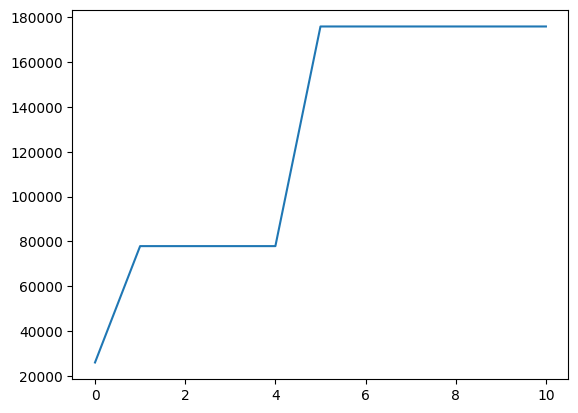

In [39]:
import matplotlib.pyplot as plt
y = [i['max'] for i in logbook]
plt.plot(range(len(y)), y)

In [40]:
best_solution = hof.items[0]
tc = 0.01
print("TRAIN")
print("Buy and hold:",(1000/btc_train.iloc[0]['Open'])*btc_train.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(btc_train))
print("strat value :",trading_strat(individual = best_solution, df=btc_train,pset=pset)[0],'\n')

print("TEST")
print("Buy and hold:",(1000/btc_test.iloc[0]['Open'])*btc_test.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(btc_test))
print("strat value :",trading_strat(individual = best_solution, df=btc_test,pset=pset)[0])

TRAIN
Buy and hold: 83253.63449103477
mtv         : 357092212810.1182
strat value : 305954.22551383614 

TEST
Buy and hold: 821.1862203587319
mtv         : 142111.3274398169
strat value : 874.684335010004


or_(gt(ma_close_2, ma_close_5), gt(ma_volume_8, 'lag_volume_17'))


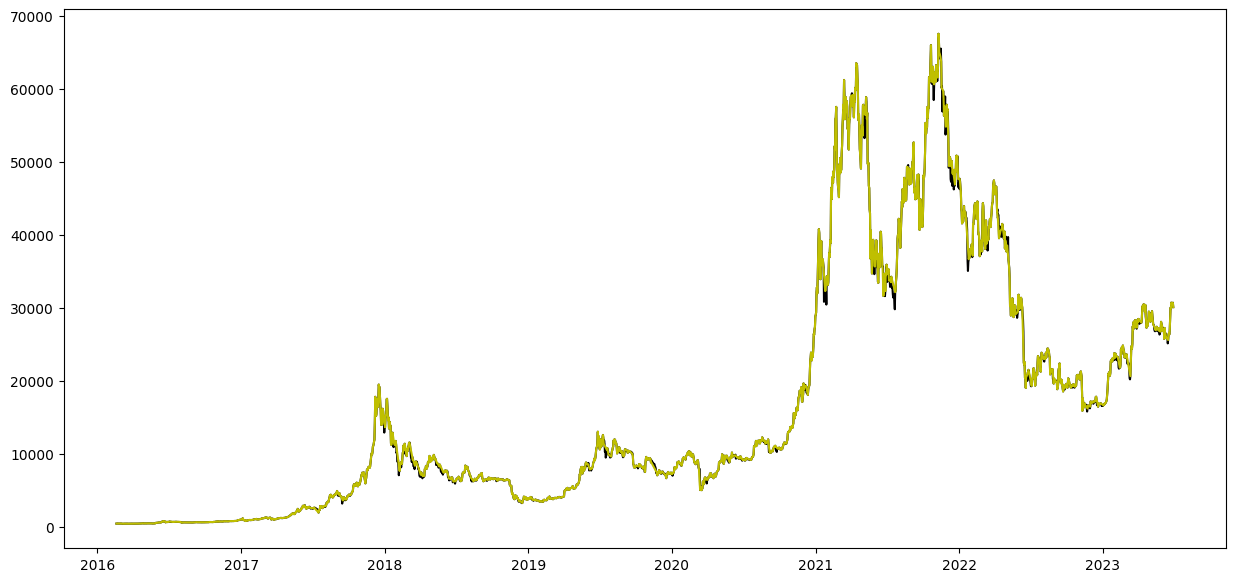

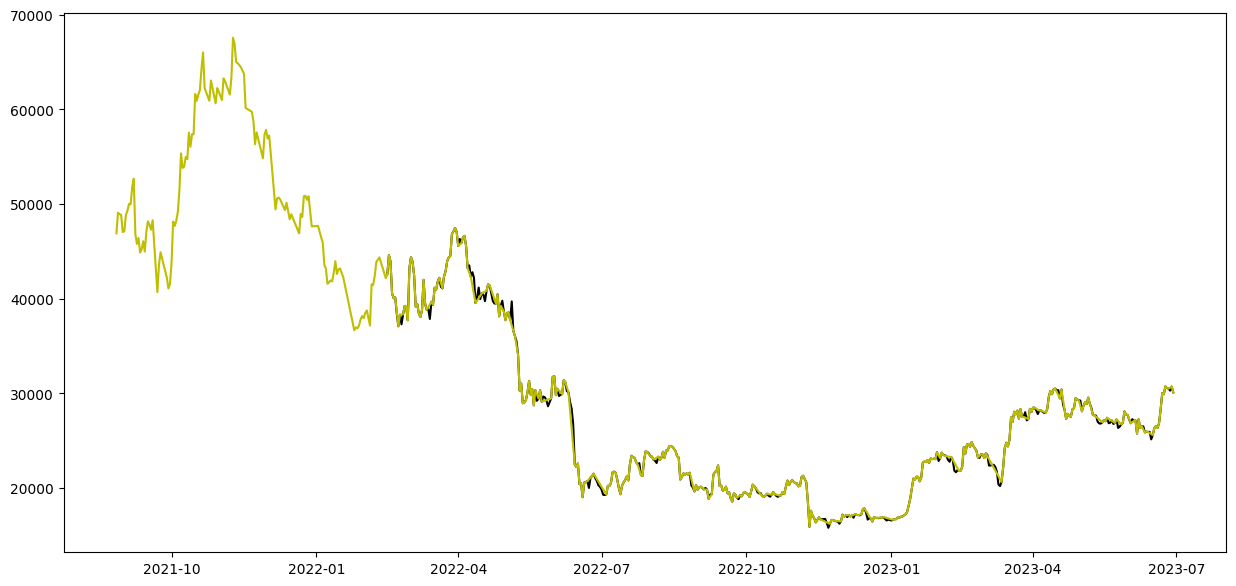

In [50]:
#Check best solution:
print(str(best_solution))
plot_tree(expr = best_solution,
          name=f"tree_best_solution_{pendulum.now().format("MM-DD_HH-mm-ss")}")
function = gp.compile(expr=gp.PrimitiveTree(best_solution),pset=pset)
signal_df  = pd.DataFrame(index=btc_ts.index)
signal_df['Signal'] = function(df = btc_ts)
signal_df["Open"] = btc_ts['Open']
plt.figure(figsize=(15,7))
# btc_ts['Open'].plot()
x_btc = list(btc_ts.index)
y_btc = list(btc_ts['Open'])

x_sig = list(signal_df[signal_df['Signal']].index)
y_sig= list(signal_df[signal_df['Signal']]['Open'])
plt.plot(x_btc,y_btc,'k')
plt.plot(x_sig,y_sig,'y')

plt.figure(figsize=(15,7))
plt.plot(x_btc[-500:],y_btc[-500:],'k')
plt.plot(x_sig[-500:],y_sig[-500:],'y')

In [42]:
# Get random Profit
def random_trading(df, val = 1000):
    ts_val = [val]
    ts_df = pd.DataFrame(columns = ["value"])
    long=False

    for cnt,row in enumerate(df['Open'].to_frame().iterrows()):
        gd = random.random()
        if  gd<1/3:
            "Try to buy for 33% of the time"
            if long:
                pass
            else:
                shares = ((1-tc)*val)/row[1]['Open']
                long=True
        elif gd <2/3:
            if long:
                val = (1-tc)*shares*row[1]['Open']
                long=False
            else:
                pass       
        else:
            pass
            
            long=False
        if cnt == len(df) and long:
            val = shares*row[1]['Open']
        ts_val.append(val)
        ts_df.loc[row[0]] = val
    return val, ts_val, ts_df


Random trading strategy value:  6.758858335554322


<Axes: >

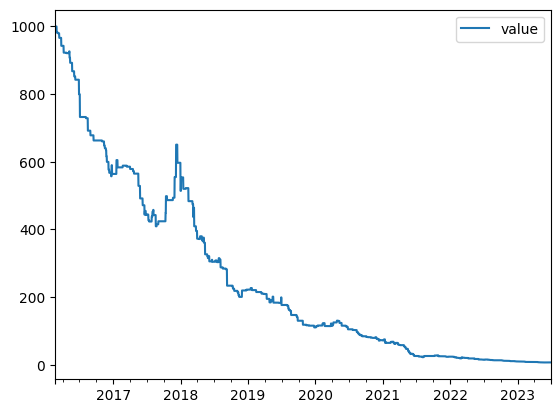

In [43]:
val_r, ts_val_r, ts_df_r = random_trading(btc_ts)
print("Random trading strategy value: ",val_r)
ts_df_r.plot()

In [44]:
ts_df.plot()
# ts_df["2021-06-30":].plot()

NameError: name 'ts_df' is not defined

<Axes: xlabel='Date'>

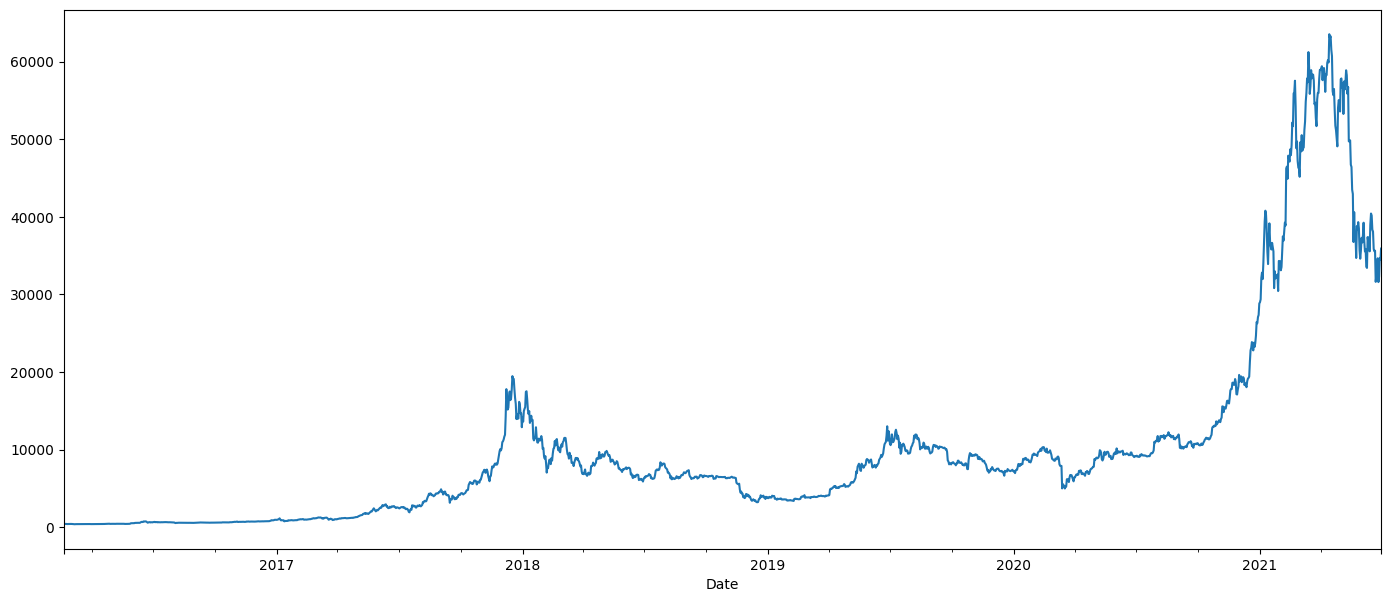

In [45]:
plt.figure()
btc_train["Open"].plot(figsize=(17,7))

In [46]:
btc_train_open = btc_train['Open']
x = btc_train_open.reset_index()['Open']

# Get peaks and troughs
peaks, _ = find_peaks(x)
troughs, _ = find_peaks(-x)

peaks_troughs = list(peaks)+list(troughs)
#Add the enedpoints to the local maximum and minimums.
if 0 not in peaks_troughs:
    peaks_troughs.append(0)
if len(btc_train_open)-1 not in peaks_troughs:
    peaks_troughs.append(len(btc_train_open)-1)

peaks_troughs = sorted(peaks_troughs)
peaks_troughs

#Work out maximum theoretical value using an initial investement of $1000 by default.
profit=0
val = 1000
no_tc_val = 1000
for ind,price in enumerate(btc_train_open.iloc[peaks_troughs]):
    if ind>1 and price > btc_train_open.iloc[peaks_troughs].iloc[ind-1]:
        # Calculate 
        pot_val= (val*price/btc_train_open.iloc[peaks_troughs].iloc[ind-1])*(1-tc)**2
        if pot_val>val:
            val=pot_val        
# no_tc
if ind>1 and price > btc_train_open.iloc[peaks_troughs].iloc[ind-1]:
    no_tc_val = (no_tc_val*price/btc_train_open.iloc[peaks_troughs].iloc[ind-1])

val

np.float64(357092212810.1182)

In [71]:
eth_ts = yf.Ticker("TSLA").history(start='2016-01-01', end='2023-06-30')

base_columns_list = ['Open', 'High', 'Low', 'Close', 'Volume']

for column in base_columns_list:
    for lag in range(2,50):
        create_ma_columns(df = eth_ts,column=column, lag = lag)
    for lag in range(1,50):
        create_lagged_columns(df = eth_ts,column=column, lag = lag)
    for lag in range(10):
        create_percentage_of_value(df = eth_ts,column=column)

print("TEST ETH")
print("Buy and hold:",(1000/eth_ts.iloc[0]['Open'])*eth_ts.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(eth_ts))
print("strat value :",trading_strat(individual = best_solution, df=eth_ts, pset=pset)[0])
print("MDD :",trading_strat(individual = best_solution, df=eth_ts, pset=pset)[1])
ts_val_eth = trading_strat(individual = best_solution, df=eth_ts, pset=pset)[2]

/tmp/ipykernel_768564/3535242035.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/tmp/ipykernel_768564/3535242035.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/tmp/ipykernel_768564/3535242035.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

TEST ETH
Buy and hold: 16441.695659948968
mtv         : 224817826489.2217
strat value : 4542.19532283167
MDD : -2437.421696611078


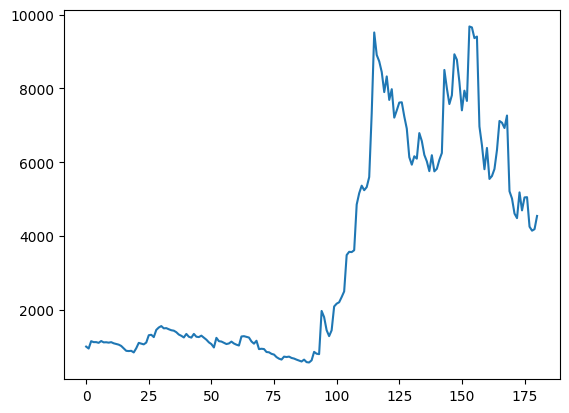

In [72]:
plt.plot(range(0,len(ts_val_eth)), ts_val_eth)

<Axes: xlabel='Date'>

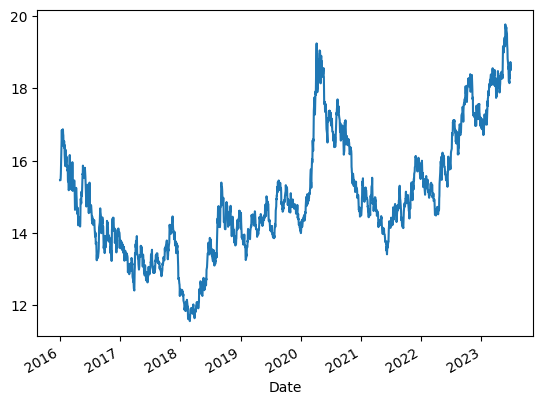

In [70]:
eth_ts['Open'].plot()

In [49]:
hof.

SyntaxError: invalid syntax (530104135.py, line 1)

In [ ]:
deap.tools.support.HallOfFame

In [ ]:
logbook